In [1]:
import glob,os
from tqdm import tqdm
import pandas as pd
import numpy as np
from rdkit import Chem,RDLogger
from tqdm import tqdm
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole
from catemb.data import CatDataset
from catemb.utils import link_lig_to_metal
from copy import deepcopy
RDLogger.DisableLog('rdApp.*')
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400, 400
pt = Chem.GetPeriodicTable()
random_seed = 42

/opt/conda/envs/catemb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Build ligand-metal complex

In [2]:
smiles_geom_info = np.load('../dataset/processed/original_smiles.npy',allow_pickle=True).item()
len(smiles_geom_info)

12797

### SadPhos

In [70]:
metal_lst = [("Ni",2),("Pd",2),("Cu",2),("Ni",0),("Pd",0),("Cu",0)]
sadphos_smarts_idx_map = {'O=[SX3]([*:4])[N]([*:3])[C]([H])([*:1])([*:2]).[PX3]([#6])([#6])':[9,1],          # P, S
                      '[*][SX3](N([*])[CX4;!R]([*])C1=CC=CC=C1[PX3]([#6])([#6]))=O': [12,1],
                      '[*][CX4;!R]([CX4;!R][PX3]([#6])[#6])N([*])[S@@X3]([*])=O': [3,8],
                      '[*]C1([*])C2=C(C([CX4;!R]([*])N(*)[S@@X3]([*])=O)=CC=C2)OC3=C([PX3]([#6])([#6]))C=CC=C31':[19, 10],
                      'PccCN([*])[S@@X3]([*])=O':[0,6]}

cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in sadphos_smarts_idx_map.keys(): ###
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = sadphos_smarts_idx_map[smarts] ###
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['P','S']:
                    check = False
                    break
            if not check:
                continue
            for metal,chrg in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx,chrg)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,'metal':metal})
    
print(len(cat_dataset))
np.save("../dataset/processed/sadphos_complex_new.npy",cat_dataset)

100%|██████████| 12797/12797 [00:09<00:00, 1280.29it/s]

11424


### PHOX

In [71]:
phox_smarts_idx_map = {'P-[#6,#7]~[#6]-[C;H0]1=N[C,c][C,c]O1':[0,4],
                       'P-[#6,#7]~[#6]~[#6]-[C;H0]1=N[C,c][C,c]O1':[0,5],
                       'P-[#6,#7]~[#6]~[#6]~[#6]-[C;H0]1=N[C,c][C,c]O1':[0,6],
                       'P-[#6,#7]~[#6]~[#6]~[#6]~[#6]-[C;H0]1=N[C,c][C,c]O1':[0,7]}
metal_lst = [("Ir",1),("Ni",2),("Pd",2),("Pd",0),("Co",2),("Cu",1),("Cu",2),("Ag",1),("Rh",1)]
cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in phox_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = phox_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['P','N']:
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal,chrg in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx,chrg)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,'metal':metal
                                    })
print(len(cat_dataset))
np.save("../dataset/processed/phox_complex_new.npy",cat_dataset)

100%|██████████| 12797/12797 [00:03<00:00, 4209.73it/s]

900


### BOX

In [72]:
box_smarts_idx_map = {'O1[C,c][C,c]N=[C]1~[#6]~[C]2=N[C,c][C,c]O2':[3,7],
                      'O1[C,c][C,c]N=[C]1~[c]~[n]~[c]~[C]2=N[C,c][C,c]O2':[3,6,9],
                      'O1[C,c][C,c]N=[C]1~[c]~[c]~[c]~[c]~[C]2=N[C,c][C,c]O2':[3,10]}
metal_lst = [("Cu",1),("Cu",2),("Fe",2),("Fe",3),("Au",3),("Sn",2),("Pd",2),("Zn",2),("Ni",2)]
cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in box_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = box_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['N']:
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal,chrg in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx,chrg)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,'metal':metal})
print(len(cat_dataset))
np.save("../dataset/processed/box_complex_new.npy",cat_dataset)

100%|██████████| 12797/12797 [00:03<00:00, 3645.71it/s]

2277


### Salen

In [73]:

rxn = AllChem.ReactionFromSmarts("([O;H1:1]-[c:2]1:[c:3](-[C:4]=[N,n:5]~[#6:6]~[#6:7]~[N,n:8]=[C:9]-[c:10]2:[c:11](-[O;H1:12]):[c:13]:[c:14]:[c:15]:[c:16]2):[c:17]:[c:18]:[c:19]:[c:20]1)>>([O-:1]-[c:2]1:[c:3](-[C:4]=[N,n:5]~[#6:6]~[#6:7]~[N,n:8]=[C:9]-[c:10]2:[c:11](-[O-:12]):[c:13]:[c:14]:[c:15]:[c:16]2):[c:17]:[c:18]:[c:19]:[c:20]1)")
salen_smarts_idx_map = {'O-c1ccccc1-C=[N,n]~[#6]~[#6]~[N,n]=C-c2ccccc2O':[0,8,11,19]}
metal_lst = [("Mn",3),("Co",2),("Co",3),("Ti",4),("Ir",4),("Ni",2),("Zn",2),("Cu",2)]
cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    
    for smarts in salen_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = salen_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            pdts = rxn.RunReactants((mol,))
            if len(pdts) == 0:
                continue
            mol_ = pdts[0][0]
            mol_ = Chem.AddHs(mol_)
            match_at_idx_lst = mol_.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol_.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['N','O']: ###
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal,chrg in metal_lst:
                cat_mol = link_lig_to_metal(mol_,metal,link_atom_idx,chrg)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,'metal':metal
                                    })
print(len(cat_dataset))
np.save("../dataset/processed/salen_complex_new.npy",cat_dataset) ###

100%|██████████| 12797/12797 [00:02<00:00, 5814.78it/s]

104


### Bisphosphine

In [74]:
bisphos_smarts_idx_map = {'[P]~[#6,c]~[P]':[0,2],
 '[P]~[#6,c]~[#6,c]~[P]':[0,3],
 '[P]~[#6,c]~[#6,c]~[#6,c]~[P]':[0,4],
 '[P]~[#6,c]~[#6,c]~[#6,c]~[#6,c]~[P]':[0,5],
 'P-c1c2ccccc2ccc1-c3c(P)ccc4ccccc34':[0,13],
 'PC12C3C4C5C1[Fe]25436789C%10C6C7C8C%109P':[0,12],
 '[P;H0](-[#6])([-#6])-[#6]~[#6]~[P;H0](-[#6])-[#6]':[0,5],
 "[P]-[N]-[c]~[c]~[c]~[c]-[N]-[P]":[0,7],
 "[P]-[c]~[c]-[C]-[C]-[c]~[c]~[c]-[P]":[0,8],
 "[P]-[c]~[c]~[A]~[c]~[c]-[P]":[0,6]
 }
metal_lst = [("Co",2),("Ni",2),("Cu",1),("Rh",1),("Ir",1),("Ir",3),("Zn",2),("Fe",2),("Ru",2),("Mn",1),("Pd",2)]

cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in bisphos_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = bisphos_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['P']: ###
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal,chrg in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx,chrg)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,'metal':metal
                                    })
print(len(cat_dataset))
np.save("../dataset/processed/bisphos_complex_new.npy",cat_dataset) ###

100%|██████████| 12797/12797 [00:05<00:00, 2469.11it/s]

3201


### NHC

In [75]:
nhc_smarts_idx_map = {'[n,N,n+,N+]1~[c,C;H1]~[n,N,n+,N+]~[c,C]~[c,C]1':[1]}
dehydrogen_rxn_template = "([n,N,n+,N+:1]1~[c,C;H1:2]~[n,N,n+,N+:3]~[c,C:4]~[c,C:5]1)>>([n,N:1]1~[c,C;H0:2]~[n,N:3]~[c,C:4]~[c,C:5]1)"
metal_lst = [("Au",1),("Au",3),("Rh",1),("Pd",2),("Cu",2),("Ni",2),("Ir",1),("Ir",3),("Ru",2)]
rxn = AllChem.ReactionFromSmarts(dehydrogen_rxn_template)
cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in nhc_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = nhc_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['C']: ###
                    check = False
                    print(123)
                    break
            if not check:
                continue
            
            for metal,chrg in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx,chrg)
                res_mol = rxn.RunReactants((Chem.RemoveHs(cat_mol),))[0][0]
                cat_smi = Chem.MolToSmiles(res_mol)
                if Chem.MolFromSmiles(cat_smi) is None:
                    continue
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,'metal':metal
                                    })
print(len(cat_dataset))
np.save("../dataset/processed/nhc_complex_new.npy",cat_dataset) ###

100%|██████████| 12797/12797 [00:03<00:00, 4171.16it/s]

855


### Amino Acid

In [76]:
anion_amino_acid_idx_lst = [0,3]
neutral_amino_acid_smiles = '[N][CX4][C](=[O])[O;H1]'
anion_amino_acid_smarts = '[N][CX4][C](=[O])[O;H0-]'
dehydrogen_rxn_template = "[N:5][CX4:1][C:2](=[O:3])[O;H1:4]>>[N:5][CX4:1][C:2](=[O:3])[O-1:4]"
neutral_amino_acid_mol = Chem.MolFromSmarts(neutral_amino_acid_smiles)
anion_amino_acid_mol = Chem.MolFromSmarts(anion_amino_acid_smarts)
rxn = AllChem.ReactionFromSmarts(dehydrogen_rxn_template)
metal_lst = [("Pd",2)]
cat_dataset = []
cat_mol_lst = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    
    
    if mol.HasSubstructMatch(neutral_amino_acid_mol):
        pdt_mols = rxn.RunReactants((mol,))
        mol = pdt_mols[0][0]
    elif mol.HasSubstructMatch(anion_amino_acid_mol):
        mol = mol
    else:
        continue
    mol = Chem.AddHs(mol)
    match_at_idx_lst = mol.GetSubstructMatch(anion_amino_acid_mol)
    link_atom_idx = [match_at_idx_lst[idx] for idx in anion_amino_acid_idx_lst]
    check = True
    for atom_idx in link_atom_idx:
        atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
        if atom_symbol not in ['N','O']:
            check = False
            print(123)
            break
    if not check:
        continue
    for metal,chrg in metal_lst:
        cat_mol = link_lig_to_metal(mol,metal,link_atom_idx,chrg)
        cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
        #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
        
        #if flag == 0:
        cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,'metal':metal
                            })
        cat_mol_lst.append(cat_mol)
    
print(len(cat_dataset))
np.save("../dataset/processed/amino_acid_complex_new.npy",cat_dataset) ###



100%|██████████| 12797/12797 [00:02<00:00, 6294.30it/s]

1649


In [6]:
len(cat_dataset)
cat_dataset[0]

{'cat_smiles': '[O-]C1=[O]->[Pd+2]<-[NH]2CSC[C@@H]12',
 'lig_smiles': 'O=C(O)[C@@H]1CSCN1'}

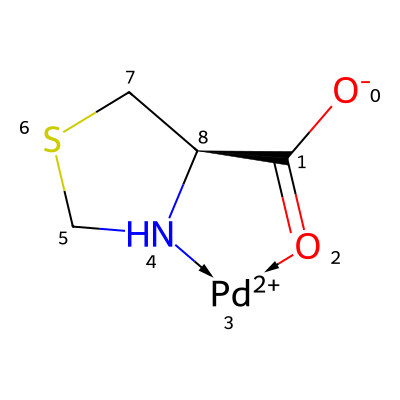

In [7]:
Chem.MolFromSmiles("[O-]C1=[O]->[Pd+2]<-[NH]2CSC[C@@H]12")

### N,N'-Dioxide

In [77]:
nn_dioxide_smarts_idx_map = {'[O-][N+]1(CCCCC1C=O)CCC[N+]2(C(C=O)CCCC2)[O-]':[0,8,15,20],
                          '[O-][N+]1(CCC[N+]2([O-])CCCC2C=O)CCCC1C=O':[0,6,12,18]}
metal_lst = [("Sc",2),("La",3),("Yb",3),("Y",3),("Cu",2),("Gd",3),("Co",2),("Ni",2),("Mg",2),("Zn",2),("Fe",3),("Ce",3),
             ("Nd",3),("Ho",3),("Er",3),("Ba",2),("Pr",3),("Sm",3),("Eu",3),("Tb",3),("Dy",3),("Tm",3),("Lu",3)]
cat_dataset = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in nn_dioxide_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = nn_dioxide_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['O']: ###
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal,chrg in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx,chrg)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,'metal':metal
                                    })
print(len(cat_dataset))
np.save("../dataset/processed/nn_dioxide_complex_new.npy",cat_dataset) ###


100%|██████████| 12797/12797 [00:03<00:00, 3431.53it/s]


1495


In [11]:
cat_dataset[0]

{'cat_smiles': 'CCOc1cccc(OCC)c1NC1=[O]->[Sc+2]23<-[O]=C(Nc4c(OCC)cccc4OCC)[C@@H]4CCCC[N@+]4(CCC[N@+]4([O-]->2)CCCC[C@@H]14)[O-]->3',
 'lig_smiles': 'CCOc1cccc(OCC)c1NC(=O)[C@@H]1CCCC[N@@+]1([O-])CCC[N@+]1([O-])CCCC[C@H]1C(=O)Nc1c(OCC)cccc1OCC'}

In [143]:
cat_smi

'CC(C)(C)c1cc(NC2=[O]->[Au]34<-[O]=C(Nc5cc(C(C)(C)C)cc(C(C)(C)C)c5)[C@H]5CCC[N@@+]5(CCC[N@@+]5([O-]->3)CCC[C@H]25)[O-]->4)cc(C(C)(C)C)c1'

### Monophosphine

In [53]:
def link_newlig_to_cat(lig_mol,cat_mol,metal_type,coord_at_idx_lst,metal_at_idx=None):
    if metal_at_idx is None:
        metal_at_idx = cat_mol.GetNumAtoms() - 1
    assert cat_mol.GetAtomWithIdx(metal_at_idx).GetSymbol() == metal_type
    rw_cat_mol = Chem.RWMol(cat_mol)
    rw_cat_mol.UpdatePropertyCache(strict=False)

    rw_lig_mol = Chem.RWMol(lig_mol)
    rw_lig_mol.UpdatePropertyCache(strict=False)

    rw_cat_mol.InsertMol(rw_lig_mol)

    for at_idx in coord_at_idx_lst:
        rw_cat_mol.AddBond(at_idx+cat_mol.GetNumAtoms(),metal_at_idx,Chem.BondType.DATIVE)
    rw_cat_mol.UpdatePropertyCache(strict=True)
    cat_mol = rw_cat_mol.GetMol()
    return cat_mol,metal_at_idx

In [78]:
monophos_smarts_idx_map = {'[P;X3;H0;v3;!$(P=[O,S,N])](-[#6,c])(-[#6,c])-[#6,c]':[0],
                          }
metal_lst = [("Pd",2),("Pd",0),("Rh",1),("Ru",2),("Ni",0),("Ni",2),("Au",1),("Cu",1)]
cat_dataset = []
cat_mols = []
for smiles in tqdm(smiles_geom_info.keys()):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for smarts in monophos_smarts_idx_map.keys(): ####
        smarts_mol = Chem.MolFromSmarts(smarts)
        idx_lst = monophos_smarts_idx_map[smarts] ####
        if mol.HasSubstructMatch(smarts_mol):
            match_at_idx_lst = mol.GetSubstructMatch(smarts_mol)
            if len(mol.GetSubstructMatches(smarts_mol)) > 1:
                continue
            link_atom_idx = [match_at_idx_lst[idx] for idx in idx_lst]
            check = True
            for atom_idx in link_atom_idx:
                atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                if atom_symbol not in ['P']: ###
                    check = False
                    print(123)
                    break
            if not check:
                continue
            for metal,chrg in metal_lst:
                cat_mol = link_lig_to_metal(mol,metal,link_atom_idx,chrg)
                single_lig_version = deepcopy(cat_mol)
                if metal == 'Au':
                    pass
                else:
                    cat_mol,metal_at_idx = link_newlig_to_cat(mol,cat_mol,metal,link_atom_idx)
                    double_lig_version = deepcopy(cat_mol)
                    if metal == "Rh":
                        cat_mol,metal_at_idx = link_newlig_to_cat(mol,cat_mol,metal,link_atom_idx,metal_at_idx)
                cat_smi = Chem.MolToSmiles(Chem.RemoveHs(cat_mol))
                #flag = AllChem.EmbedMolecule(cat_mol,randomSeed=random_seed)
                #if flag == 0:
                cat_dataset.append({'cat_smiles':cat_smi,'lig_smiles':smiles,'metal':metal})
                cat_mols.append(cat_mol)
                if metal != "Au":
                    cat_dataset.append({'cat_smiles':Chem.MolToSmiles(Chem.RemoveHs(single_lig_version)),'lig_smiles':smiles,'metal':metal})
                    cat_mols.append(single_lig_version)
                    if metal == "Rh":
                        cat_dataset.append({'cat_smiles':Chem.MolToSmiles(Chem.RemoveHs(double_lig_version)),'lig_smiles':smiles,'metal':metal})
                        cat_mols.append(double_lig_version)
print(len(cat_dataset))
np.save("../dataset/processed/monophos_complex_new.npy",cat_dataset) ###


100%|██████████| 12797/12797 [00:24<00:00, 516.69it/s] 

37056


## Integrating data

In [4]:
data_files = sorted(glob.glob("../dataset/processed/*complex_new.npy") + ['../dataset/processed/original_smiles.npy'])    # the `*complex_new.npy` files can be generated by running the above code
lig_cat_dataset = []
existed_smiles = []
for data_file in data_files:
    dataset = np.load(data_file,allow_pickle=True)
    if 'original_smiles' in data_file:
        dataset = dataset.item()
        for smiles in dataset:
            if smiles not in existed_smiles:
                existed_smiles.append(smiles)
                lig_cat_dataset.append({"smiles":smiles})
    else:
        for data in dataset:
            if data["cat_smiles"] not in existed_smiles:
                existed_smiles.append(data["cat_smiles"])
                lig_cat_dataset.append({"smiles":data["cat_smiles"]})

In [5]:
len(lig_cat_dataset)

66664

In [150]:
lig_cat_dataset[1000]

{'smiles': 'O=C1CC[C@@H]2C([O-])=[O]->[Ag]<-[NH]12'}

In [6]:
np.save("../dataset/processed/lig_cat_dataset_new.npy",lig_cat_dataset)

## Dataset with xTB-optimized geometries

Then we perform optimization on all molecules in `lig_cat_dataset_new.npy` with xTB. The dataset with optimized molecules is saved as `catcompdb.npy`.

Load this dataset like this 👇

In [2]:
cat_dataset = CatDataset(root="../dataset/processed",name="catcompdb",read_coord=True,save_smiles=True)

Processing...


[INFO] Shuffling dataset with seed: 42


100%|██████████| 62755/62755 [01:55<00:00, 542.75it/s]
Done!


In [3]:
cat_dataset

CatDataset(62755)